# Inférer la structure de graph à partir de réalisation

In [89]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False

### Simuler des données synthétiques

#### RBF random graphe

In [90]:
def rbf_random_graph(num_vertices, sigma=0.5, kappa=0.6):
    # tirage aléatoire des sommets dans le carré unité
    vertices = np.random.random(size=(num_vertices, 2))
    # construction de la matrice d'adjacence
    W = np.zeros((num_vertices, num_vertices))
    for i in range(0, num_vertices):
        for j in range(i+1, num_vertices):
            dist = np.linalg.norm(vertices[i]-vertices[j])
            if dist < kappa:
                W[i, j] = np.exp(-dist**2/(2*sigma**2))
                W[j, i] = np.exp(-dist**2/(2*sigma**2))
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    return L / np.trace(L) * num_vertices

In [91]:
def er_random_graph(num_vertices, p=0.2):
    W = np.zeros(shape=(num_vertices, num_vertices))
    for i in range(0, num_vertices):
        # no self-loop
        for j in range(i+1, num_vertices):
            # tirage aléatoire des arrêtes selon une loi de Bernoulli
            W[i, j] = np.random.binomial(n=1, p=p)
            W[j, i] = W[i, j]
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    return L / np.trace(L) * num_vertices

#### Generating graph signal

Le modèle du signal est:
$$ x = \mathcal{D}h + \epsilon$$
où $h$ est une variable latente, $\mathcal{D}$ est la matrice de représentation. Dans la suite, nous ferons l'hyptohèse que des informations sur la structure du graphe sont contenues dans cette matrice. En particulier, on peut supposer que D est un dictionnaire de motifs spectraux du graph. 

Dans la suite, nous allons nous intéresser aux processes de diffusion sur graphs. La matrice du Laplacien sera utilisée pour modéliser cette diffusion (cf equation de la chaleur). 
$$ D = [exp(-\tau_1 L), exp(-\tau_2), ...]$$

In [92]:
def computing_dynamic_matrix(laplacian, diffusion_factors):
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    for i, tau in enumerate(diffusion_factors):
        if i == 0:
            D = eigenvectors @ np.diag(np.exp(-tau * eigenvalues)) @ eigenvectors.T
        else:
            D = np.concatenate([D, eigenvectors @ np.diag(np.exp(-tau * eigenvalues)) @ eigenvectors.T], axis=1)
    return D

In [93]:
def graph_signal_generator(laplacian, diffusion_factors, n_samples):
    num_vertices = laplacian.shape[0]
    num_diffusions = len(diffusion_factors)
    dynamic_matrix = computing_dynamic_matrix(laplacian, diffusion_factors)
    samples = np.zeros(shape=(n_samples, num_vertices))
    activations = np.zeros(shape=(n_samples, num_vertices*num_diffusions))
    for i in range(n_samples):
        # pour chaque échantillon, nous choisissons des activations au hasard
        indices = np.random.choice(np.arange(num_vertices * num_diffusions), 3, replace=False)
        # nous choississons des températures initiales gaussiennes
        init_heat = np.random.normal(size=(3,))
        activations[i, indices] = init_heat
        # nous calculons finalement le signal sur le graph
        samples[i] = np.ravel(dynamic_matrix @ activations[i])
    return samples, activations

## Learning heat diffusion graphs

In [96]:
def reconstruction_loss(samples, 
                        laplacian, 
                        activations, 
                        diffusion_factors):

    D = computing_dynamic_matrix(laplacian, diffusion_factors)
    return np.linalg.norm(samples-activations.dot(D.T), ord='fro')**2


def objective_function(samples, 
                      laplacian, 
                      activations, 
                      diffusion_factors, 
                      alpha, 
                      beta):
    """
    alpha : L1 regularization of H (activations)
    beta : L2 regularization of L (laplacian)
    """
    obj = reconstruction_loss(samples, laplacian, activations, diffusion_factors)
    obj += beta * np.linalg.norm(laplacian, ord='fro')
    obj += alpha * np.linalg.norm(np.ravel(activations), ord=1)
    
    return obj

def grad_tr_A_exp_L(eigenvalues, eigenvectors, A):
    """grad of tr(Aexp(L)) wrt L when L is symmetric"""
    
    num_vertices = len(eigenvalues)
    B = np.zeros(shape=(num_vertices, num_vertices))
    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if eigenvalues[i] == eigenvalues[j]:
                B[i, i] = np.exp(eigenvalues[i])
            else:
                B[i, j] = (np.exp(eigenvalues[i]) - np.exp(eigenvalues[j])) / (eigenvalues[i] - eigenvalues[j])
                B[j, i] = B[i, j]
    grad = eigenvectors @ ((eigenvectors.T @ A.T @ eigenvectors) * B) @ eigenvectors.T
    
    return grad

def grad_wrt_L(samples, laplacian, activations, diffusion_factors):
    """gradient of the reconstruction error with respect to L"""
    
    num_vertices = samples.shape[1]
    grad = np.zeros(shape=(num_vertices, num_vertices))
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    for i, tau in enumerate(diffusion_factors):
        
        H_tau = activations[:, num_vertices*i:num_vertices*(i+1)]
        A = H_tau.T @ samples
        grad -= 2 * (- tau * grad_tr_A_exp_L(- tau * eigenvalues, eigenvectors, A))
        
        for j, tau_bis in enumerate(diffusion_factors):
            
            H_tau_bis = activations[:, num_vertices*j:num_vertices*(j+1)]
            A = H_tau_bis.T @ H_tau
            grad += - ((tau+tau_bis) *  grad_tr_A_exp_L(-(tau+tau_bis)*eigenvalues, eigenvectors, A))
    
    return grad

def grad_wrt_tau(samples, 
                 laplacian, 
                 activations, 
                 diffusion_factors):
    
    N = num_vertices = samples.shape[1]
    grad = np.zeros(shape=len(diffusion_factors))
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    
    for i, tau in enumerate(diffusion_factors):
        
        grad[i] += 2 * np.trace(activations[:, N*i:N*(i+1)].T @ samples @ L @ \
                                eigenvectors @ np.diag(np.exp(- tau * eigenvalues)) @ eigenvectors.T)
        
        for j, tau_bis in enumerate(diffusion_factors):
            grad[i] -= 2 * np.trace(activations[:, N*j:N*(j+1)].T @ activations[:, N*i:N*(i+1)] @ L @ \
                                    eigenvectors @ np.diag(np.exp(-(tau + tau_bis) * eigenvalues)) @ eigenvectors.T)
            
    return grad

    
def op_proximal_norm1(z, c, alpha):
    return np.sign(z) * np.maximum(np.abs(z)-alpha/c, np.zeros(shape=len(z)))


def cond_descent_lemma(samples, 
                        new_laplacian, 
                        laplacian, 
                        activations, 
                        diffusion_factors, 
                        C2):

    left_side = reconstruction_loss(samples, new_laplacian, activations, diffusion_factors)
    right_side = reconstruction_loss(samples, laplacian, activations, diffusion_factors)
    grad = grad_wrt_L(samples, laplacian, activations, diffusion_factors)
    right_side +=  np.dot(grad.flatten(), (new_laplacian-laplacian).flatten()) 
    right_side += C2 / 2 * np.linalg.norm(new_laplacian-laplacian, ord='fro')**2
    
    return left_side <= right_side
    

    
def proximal_min_prob_L(laplacian, grad, d, beta):
    
    num_vertices = laplacian.shape[0]
    
    q = matrix(grad.flatten() - d * L.flatten(), tc='d')
    P = matrix((d + 2 * beta * d) * np.eye(num_vertices**2), tc='d')
    
    A = []
    b = []
    
    # contrainte trace
    c = np.zeros((num_vertices**2,))
    for i in range(num_vertices):
        c[i*num_vertices+i] = 1
    A.append(np.copy(c))
    b.append(num_vertices)
    
    # contrainte symétrie
    for i in range(num_vertices):
        for j in range(i+1, num_vertices):
            c = np.zeros((num_vertices**2,))
            c[i*num_vertices+j] = 1
            c[j*num_vertices+i] = -1
            A.append(np.copy(c))
            b.append(0)
            
    # contrainte 1 vecteur propre pour la vp 0
    for i in range(num_vertices):
        c = np.zeros((num_vertices**2,))
        c[num_vertices*i:num_vertices*(i+1)] = 1
        A.append(np.copy(c))
        b.append(0)
        
    A = matrix(np.array(A), tc='d')
    b = matrix(np.array(b), tc='d')
    
    G = []
    h = []
    
    # contraintes termes négatifs
    for i in range(num_vertices):
        for j in range(i+1, num_vertices):
            c = np.zeros((num_vertices**2,))
            c[i*num_vertices+j] = 1
            G.append(np.copy(c))
            h.append(0)
            
    G = matrix(np.array(G), tc='d')
    h = matrix(np.array(h), tc='d')
    
    sol = np.ravel(solvers.qp(P, q, G, h, A, b)['x'])
    
    return sol.reshape((num_vertices, num_vertices))


def lipschitz_constant_wrt_H(dynamic_matrix):
    return np.linalg.norm(2 * dynamic_matrix.T @ dynamic_matrix, ord='fro')

def lipschitz_constant_wrt_tau(samples, 
                               laplacian, 
                               activations, 
                               diffusion_factors):
    
    num_vertices = laplacian.shape[0]
    res = np.zeros(shape=(len(diffusion_factors,)))
    
    for i, _ in enumerate(diffusion_factors):
        
        res[i] += 2 * np.linalg.norm(activations[:, num_vertices*i:num_vertices*(i+1)]) * np.linalg.norm(samples)
        
        for j, _ in enumerate(diffusion_factors):
            res[i] += 4 * np.linalg.norm(activations[:, num_vertices*i:num_vertices*(i+1)]) * \
            np.linalg.norm(activations[:, num_vertices*j:num_vertices*(j+1)])
    
    return np.linalg.norm(laplacian@laplacian, ord=2)**2 * np.max(res)
    # encore une erreur de l'énoncé ?
    #return np.linalg.norm(laplacian, ord=2)**2 * np.max(res) 

In [138]:
def learn_heat(samples,
               n_step=20, 
               alpha=1e-6, 
               beta=1e-2, 
               gamma1=1.5, 
               gamma2=1.5, 
               gamma3=1.5, 
               s=2,
               true_L=None,
               true_H=None, 
               true_tau=None
               ):
    
    num_samples, num_vertices = samples.shape
    
    # initialisation
    diffusion_factors = np.array([1*np.random.random() for _ in range(s)])
    laplacian = rbf_random_graph(20)
    dynamic = computing_dynamic_matrix(laplacian, diffusion_factors) 
    activations = np.random.normal(size=(num_samples, s*num_vertices))

    # updating loops
    for step in tqdm(range(n_step)):
        
        if step % 10 == 0 and true_L is not None:
            obj = objective_function(samples, 
                                       laplacian, 
                                       activations, 
                                       diffusion_factors, 
                                       alpha, 
                                       beta)
            diff_w_gt_L = np.linalg.norm(true_L - laplacian, ord='fro')
            diff_w_gt_H = np.linalg.norm(true_H - activations, ord='fro')
            diff_w_gt_tau = np.linalg.norm(true_tau - diffusion_factors, ord=2)
            print("step {0} : obj = {1:2f}, diff gt L = {2:4f}, diff gt H = {3:4f}, diff gt tau = {4:.2f}".format(step, 
                                                                                                   obj, 
                                                                                                   diff_w_gt_L, 
                                                                                                   diff_w_gt_H, 
                                                                                                   diff_w_gt_tau))
        
        
        # updating H
        C1 = lipschitz_constant_wrt_H(dynamic)
        c_ = gamma1 * C1
        for j in range(num_samples):
            z = activations[j] - 1 / c_ * (-2 * dynamic.T @ (samples[j] - dynamic @ activations[j]))
            activations[j] = op_proximal_norm1(z, c_, alpha)
        
        
        # updating L
        eta = 1.1
        C2_init = 1
        descent_lemma_satisfied = False
        k = 0 
        old_laplacian = np.copy(laplacian)
        ### backtracking line search (for the constant C2)
        while not(descent_lemma_satisfied):
            C2 = C2_init * eta**k
            d_ = gamma2 * C2
            grad_L = grad_wrt_L(samples, laplacian, activations, diffusion_factors)
            new_laplacian = proximal_min_prob_L(old_laplacian, grad_L, d_, beta)
            k += 1
            descent_lemma_satisfied = cond_descent_lemma(samples, 
                                                        new_laplacian, 
                                                        laplacian, 
                                                        activations, 
                                                        diffusion_factors, 
                                                        C2)
            old_laplacian = new_laplacian
            
        laplacian = new_laplacian
        dynamic = computing_dynamic_matrix(laplacian, diffusion_factors)
        
        # updating tau
        e_ = gamma3 * lipschitz_constant_wrt_tau(samples, laplacian, activations, diffusion_factors)
        grad_tau = grad_wrt_tau(samples, laplacian, activations, diffusion_factors)
        diffusion_factors = np.maximum(- 1 / e_ * (grad_tau - e_ * diffusion_factors), 
                                       np.zeros(shape=(s,)))
        dynamic = computing_dynamic_matrix(laplacian, diffusion_factors)
        
    return laplacian, activations, diffusion_factors

In [139]:
# gt for ground thruth
gt_tau_list = [1.]
gt_L = rbf_random_graph(20, 0.3, 0.5)
samples, gt_H = graph_signal_generator(gt_L, gt_tau_list, 1000)
print(samples.shape)

(1000, 20)


In [140]:
L_pred, H, tau = learn_heat(samples,
                             n_step=1000, 
                             alpha=1e-3, 
                             beta=1e-3, 
                             gamma1=1.1, 
                             gamma2=1.1, 
                             gamma3=1.1, 
                             s=1, 
                             true_L=gt_L, 
                             true_H=gt_H, 
                             true_tau=gt_tau_list)
print(tau)

  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 : obj = 5714.492561, diff gt L = 2.494508, diff gt H = 152.501887, diff gt tau = 0.12
step 10 : obj = 339.688720, diff gt L = 1.766360, diff gt H = 55.027536, diff gt tau = 0.08
step 20 : obj = 65.459638, diff gt L = 1.780059, diff gt H = 30.989785, diff gt tau = 0.07
step 30 : obj = 18.757617, diff gt L = 1.858200, diff gt H = 24.403356, diff gt tau = 0.08
step 40 : obj = 8.115543, diff gt L = 1.938420, diff gt H = 23.784152, diff gt tau = 0.08
step 50 : obj = 5.468670, diff gt L = 1.974395, diff gt H = 24.230308, diff gt tau = 0.08
step 60 : obj = 4.583690, diff gt L = 1.993730, diff gt H = 24.681972, diff gt tau = 0.08
step 70 : obj = 4.242453, diff gt L = 2.005907, diff gt H = 25.043374, diff gt tau = 0.08
step 80 : obj = 4.102491, diff gt L = 2.014290, diff gt H = 25.317413, diff gt tau = 0.08
step 90 : obj = 4.043215, diff gt L = 2.020177, diff gt H = 25.521618, diff gt tau = 0.09
step 100 : obj = 4.017738, diff gt L = 2.024398, diff gt H = 25.673340, diff gt tau = 0.09
st

step 910 : obj = 3.919411, diff gt L = 2.044772, diff gt H = 25.498998, diff gt tau = 0.11
step 920 : obj = 3.918152, diff gt L = 2.044798, diff gt H = 25.489322, diff gt tau = 0.11
step 930 : obj = 3.916893, diff gt L = 2.044823, diff gt H = 25.479658, diff gt tau = 0.11
step 940 : obj = 3.915635, diff gt L = 2.044848, diff gt H = 25.470005, diff gt tau = 0.11
step 950 : obj = 3.914376, diff gt L = 2.044873, diff gt H = 25.460362, diff gt tau = 0.11
step 960 : obj = 3.913117, diff gt L = 2.044899, diff gt H = 25.450731, diff gt tau = 0.11
step 970 : obj = 3.911858, diff gt L = 2.044924, diff gt H = 25.441112, diff gt tau = 0.11
step 980 : obj = 3.910600, diff gt L = 2.044948, diff gt H = 25.431503, diff gt tau = 0.11
step 990 : obj = 3.909341, diff gt L = 2.044973, diff gt H = 25.421906, diff gt tau = 0.11
[0.88668324]


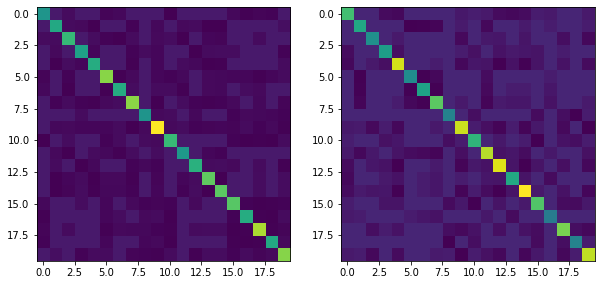

In [126]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(L_pred)
plt.subplot(1, 2, 2)
plt.imshow(gt_L)

In [130]:
print(np.linalg.norm(L_pred))
print(np.linalg.norm(gt_L))


4.753650762616772
4.935016917411098


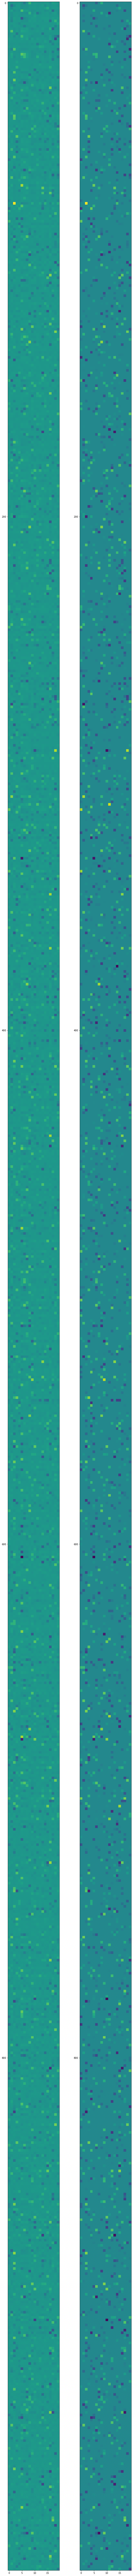

In [128]:
plt.figure(figsize=(10, 200))
plt.subplot(1, 2, 1)
plt.imshow(H)
plt.subplot(1, 2, 2)
plt.imshow(gt_H)